In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functions import *
    

In [58]:
df = pd.read_csv('factor_trading_1.csv')
df.drop(['Unnamed: 0', 'index', 'long return', 'short return', 'AskPrice2', 'BidPrice2', 'R_square_short', 'R_square_long', 'predict_long_sign', 'predict_short_sign'], axis=1, inplace=True)
#preprocess the data
new_df = df.copy()
new_df['AskPrice1'] = (new_df['AskPrice1'])
new_df['BidPrice1'] = (new_df['BidPrice1'])
new_df['predict_short'] = new_df['predict_short'] 
new_df['predict_long'] = new_df['predict_long']
# change the name of the columns
new_df.columns = ['ask', 'bid', 'prediction_50', 'prediction_100']
new_df

,ask,bid,prediction_50,prediction_100
0,772.5,772.0,0.000779,-0.000318
1,772.5,772.0,0.000779,-0.000218
2,772.5,772.0,0.000875,-0.000183
3,772.5,772.0,0.000786,-0.000253
4,772.5,772.0,0.000563,-0.000231
...,...,...,...,...
73845,766.5,766.0,0.000087,0.000106
73846,766.5,766.0,0.000086,0.000078
73847,766.5,766.0,0.000048,0.000074
73848,766.5,766.0,-0.000309,-0.000130


In [59]:
train_data = new_df.iloc[:10000]
test_data = new_df.iloc[10000:15000]
# reset the index of the test data
test_data = test_data.reset_index(drop=True)
test_data

,ask,bid,prediction_50,prediction_100
0,772.0,771.5,-0.002160,0.000159
1,772.0,771.5,-0.002061,0.000266
2,772.0,771.5,-0.001918,0.000068
3,772.0,771.5,-0.002330,-0.000027
4,772.0,771.5,-0.002240,-0.000256
...,...,...,...,...
4995,774.5,774.0,-0.001318,-0.002044
4996,774.5,774.0,-0.001550,-0.002120
4997,774.5,774.0,-0.001329,-0.001767
4998,774.5,774.0,-0.001305,-0.001593


In [60]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define the policy network
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(5, 64)  # Increased input dimension to 5
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=1)

# Initialize the neural network and optimizer
policy_net = PolicyNet()
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

# Sample training data (replace this with your actual training data)
'''
train_data = pd.DataFrame({
    'bid': np.random.rand(3000),
    'ask': np.random.rand(3000),
    'prediction_50': np.random.rand(3000),
    'prediction_100': np.random.rand(3000)
})
'''

# Training Loop
epochs = 50
total_capital_traces = []
for epoch in range(epochs):
    cash = 1000
    capital = 1000  # Initialize capital for each epoch
    holding_position = 0  # Initialize holding position

    capital_record = []  # Store capital history for plotting
    for index, row in train_data.iloc[:-1].iterrows():
        state = torch.tensor([[row['bid'], row['ask'], row['prediction_50'], row['prediction_100'], holding_position]], dtype=torch.float32)
        action_prob = policy_net(state)
        action = torch.argmax(action_prob, dim=1).item()  # Choose action (0: Buy, 1: Sell, 2: Hold)
        
        current_holding = holding_position 
        current_cash = cash
        # Simulate capital change and update holding position
        if action == 0 and holding_position < 10:  # Buy
            # capital is the mid price of the bid and ask times the holding position add cash
            cash -= row['ask']
            holding_position += 1
        elif action == 1 and holding_position > -10:  # Sell
            cash += row['bid']
            holding_position -= 1

        next_mid_price = (train_data.iloc[index+1]['bid'] + train_data.iloc[index+1]['ask']) / 2
        current_mid_price = (train_data.iloc[index]['bid'] + train_data.iloc[index]['ask']) / 2

        current_capital = current_cash + current_holding * current_mid_price
        next_capital = cash + holding_position * next_mid_price
        reward = next_capital - current_capital

        capital = next_capital
        
        # Compute loss and perform backpropagation
        loss = -torch.log(action_prob[0][action]) * reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        capital_record.append(capital)

    total_capital_traces.append(capital_record)
    


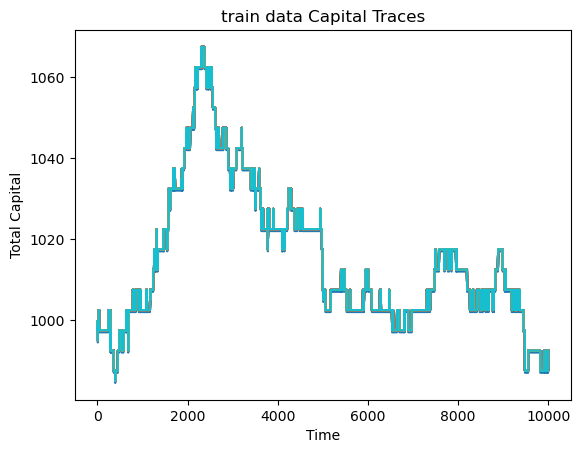

In [64]:
total_capital_traces = np.array(total_capital_traces)
# graph the total capital traces for each epoch
plt.plot(total_capital_traces.T)
plt.xlabel('Time')
plt.ylabel('Total Capital')
plt.title('train data Capital Traces')
plt.show()


In [62]:
# test the model on the trade data
'''
test_data = pd.DataFrame({
    'bid': np.random.rand(3000),
    'ask': np.random.rand(3000),
    'prediction_50': np.random.rand(3000),
    'prediction_100': np.random.rand(3000)
})
'''


test_capital_traces = []
num_paths = 50

for _ in range(num_paths):
    cash = 1000
    capital = 1000  # Initialize capital for each epoch
    holding_position = 0  # Initialize holding position
    
    catpital_trace = []
    for index, row in test_data.iloc[:-1].iterrows():
        state = torch.tensor([[row['bid'], row['ask'], row['prediction_50'], row['prediction_100'], holding_position]], dtype=torch.float32)
        action_prob = policy_net(state)
        action = torch.argmax(action_prob, dim=1).item()  # Choose action (0: Buy, 1: Sell, 2: Hold)

        current_holding = holding_position 
        current_cash = cash
        # Simulate capital change and update holding position
        if action == 0 and holding_position < 10:  # Buy
            # capital is the mid price of the bid and ask times the holding position add cash
            cash -= row['ask'] 
            holding_position += 1
        elif action == 1 and holding_position > -10:  # Sell
            cash += row['bid']
            holding_position -= 1

        next_mid_price = (test_data.iloc[index+1]['bid'] + test_data.iloc[index+1]['ask']) / 2
        current_mid_price = (test_data.iloc[index]['bid'] + test_data.iloc[index]['ask']) / 2

        current_capital = current_cash + current_holding * current_mid_price
        next_capital = cash + holding_position * next_mid_price
        reward = next_capital - current_capital

        capital = next_capital
        catpital_trace.append(capital)

    test_capital_traces.append(catpital_trace)


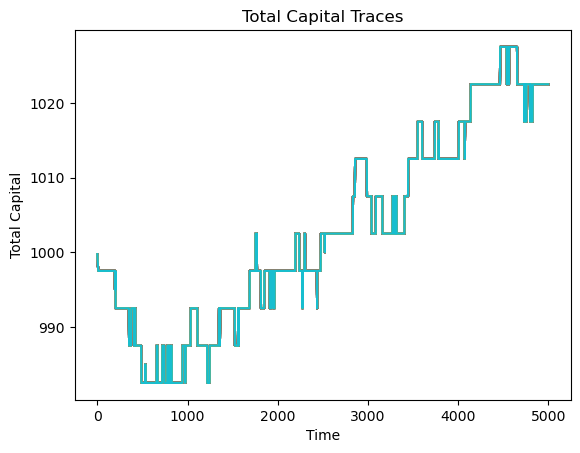

In [63]:
# graph the total capital traces for each epoch

test_capital_traces = np.array(test_capital_traces)
plt.plot(test_capital_traces.T)
plt.xlabel('Time')
plt.ylabel('Total Capital')
plt.title('Total Capital Traces')
plt.show()
